# Strategy Tester 

### Source of DATA real Metatrader Symbol Export 3 nnn years of data


`  
    DATE       TIME		OPEN	HIGH	LOW	CLOSE	TICKVOL	VOL	SPREAD  					  
  2016-01-04 10:03:00	14.51	14.51	14.42	14.46	157	114237	1  
  2016-01-04 10:04:00	14.46	14.46	14.45	14.46	4	8368	1
` 

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import glob
import datetime
import numpy as np
import datetime
from pathlib import Path
import talib as ta
import os

In [3]:
# due working at home and work windows and linux
import platform
import os

if platform.system() == 'Windows' and platform.release() == '10':
    os.chdir(r'L:\andre\PycharmProjects\geonumerics\ipython_notebooks\Stocks')
elif platform.system() == 'Windows' and platform.release() == '7':
    os.chdir(r'C:\Data\VBShared\ipython_notebooks\Stocks')
elif platform.system() == 'Linux' and platform.node() == 'riossm31012722':
    os.chdir('/media/windows/Data/VBShared/ipython_notebooks/Stocks')
elif platform.system() == 'Linux' and platform.node() == 'andre-PredatorG3571':
    os.chdir('/home/andre/PycharmProjects/gitstocks/stocks')

In [4]:
from Tools import Meta5_Ibov_Load as meta5_ibov_load

In [5]:
import importlib
importlib.reload(meta5_ibov_load)

<module 'Tools.Meta5_Ibov_Load' from '/home/andre/PycharmProjects/gitstocks/stocks/Tools/Meta5_Ibov_Load.py'>

### Set data bundle path and csv data path 

#### And Load *.csv files  if  needed

In [6]:
if platform.system() == 'Windows' and platform.release() == '10':
    meta5_ibov_load.Set_Data_Path(r'L:\andre\PycharmProjects\geonumerics\ipython_notebooks\Stocks\data',
                                 r'L:\andre\PycharmProjects\geonumerics\ipython_notebooks\Stocks\2016_stocks\2016_2018_M1')
elif platform.system() == 'Windows' and platform.release() == '7':
    meta5_ibov_load.Set_Data_Path(r'C:\Data\VBShared\ipython_notebooks\Stocks\data',
                                 r'C:\Data\VBShared\ipython_notebooks\Stocks\data')
elif platform.system() == 'Linux' and platform.node() == 'riossm31012722':
    meta5_ibov_load.Set_Data_Path(r'/media/windows/Data/VBShared/ipython_notebooks/Stocks/data',
                                r'/media/windows/Data/VBShared/ipython_notebooks/Stocks/2016_stocks/2016_2018_M1')
elif platform.system() == 'Linux' and platform.node() == 'andre-PredatorG3571':
    meta5_ibov_load.Set_Data_Path(r'/home/andre/PycharmProjects/gitstocks/stocks/data',
                            r'/home/andre/PycharmProjects/gitstocks/stocks/data')
    #os.chdir('/media/windows/Data/VBShared/ipython_notebooks/Stocks/2016_stocks\2016_2018_M1'')

master data loaded size (minutes) 507080
Symbols lodaded:
0    PETR4
1    BBDC4
2    BBAS3
3    ABEV3
4    ITUB4
5    VALE3
6     DOL$
dtype: object


In [7]:
masterdf = meta5_ibov_load.Load_Meta5_Data()

Data already loaded


### Prepare data for training and classification
and Save Data Prepared

In [8]:
df = meta5_ibov_load.FixedColumnNames()

In [9]:
df = df[150000:]

In [10]:
span = 2*60

In [11]:
ema_period = 3 # moving average period 

### Cannot create indicators or tools that are dependent of future values otherwise biased will be introduced on training

**3 classes:**  
-1 going down  (~33% data)  
0 going sideways/nowhere  (~33% data)  
1 going up  (~33% data)   

Use smoother version of prices by minutes EMA to minimize high derivatives

diff is bellow with dx=1 that's the derivative for forward differences:  
$ y[i+1]-y[i] $     

for point (i) to turn the derivative in variation of price in percent we just divide it by $y[i]$  

`price_variation(%) [i]` : $ \frac{y[i+1]-y[i]}{y[i]} $     


Note: `price_variation(%)` defines a laplace or log laplace distribution centered at zero.

In [12]:
ema = ta.EMA(df.VALE3_C.values, ema_period)
dy = np.append(np.diff(ema)/ema[:-1], np.nan) # garantee same size

In [13]:
### lets's consider for while same cutt-off for defining interval of class
### vary the definition of classes around time might be confusing for training
#ta.STDDEV(dy, )

### Better define a percentage of cutt-off between classes that doesn't create a great class inbalance

Class inbalance will be bad for training, that is known to be true

#### Bucketizing percentage of price variations... cool 

That is the target variable

In [14]:
from scipy import stats
capital=60000
# 3 classes each with 33.33% of the data
# altough the model distribution for data is a log laplacian distribution
# it's easier to rely purely on data working with percentile's
# the average will be better to a zero centered distribution
pclass = (np.percentile(dy[~np.isnan(dy)], 66.66) - np.percentile(dy[~np.isnan(dy)], 33.33))/2.
plow = stats.percentileofscore(dy, -pclass)
phigh = stats.percentileofscore(dy, pclass)
#needed = cclass
print('plow (class 0) % : ', plow, ' phigh (class 2) %: ', 100-phigh)
print('percent of data that will be sideways (class 1): %', phigh-plow)
print('decimal percent cutt-of for class {:.1e}  '.format(pclass))

plow (class 0) % :  33.23989022067884  phigh (class 2) %:  33.43256413128711
percent of data that will be sideways (class 1): % 33.327545648034054
decimal percent cutt-of for class 2.0e-04  


/home/andre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1795: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
/home/andre/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1796: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


In [15]:
print('percent cutt-of for class {:.2f} % '.format(100*pclass))

percent cutt-of for class 0.02 % 


In [16]:
def classy(x):
    if x < -pclass:
        return -1
    if x > pclass:
        return 1
    return 0

In [17]:
y = np.array(list(map(classy, dy)))
np.unique(y)

array([-1,  0,  1])

(array([118693.,      0.,      0.,      0.,      0., 119009.,      0.,
             0.,      0., 119378.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

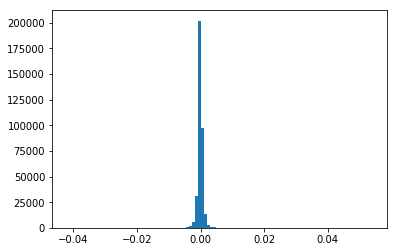

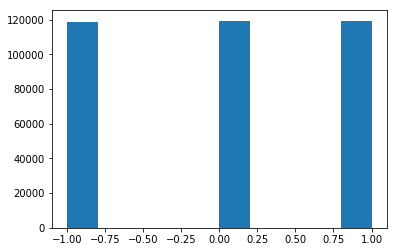

In [18]:
plt.hist(dy[~np.isnan(dy)], bins=100);
plt.figure()
plt.hist(y)

The final direction for a stock on one period of time (`span`|`expire_time`) is defined by:

$$ Dir\left(span\right) = \sum^{span}_{i=0} y[i] $$

Note that will work if `price_variation(%)` has a simetric probability distribution.

$y$ is the class vector define above

$Dir$ might be positive or negative its distribution is gaussian centered in zero. 
$Dir$ is proportional to profit for an order placed on the beginning of the period define by `span`.
Since $Dir$ tail is short for a day-trade strategy we must choose a value of dir that generates acceptable values of profit per order and orders per day. 

and the profit can be estimated from $Dir$ as:

$$ Profit \approx \left| Dir \ pclass \right| $$

All varitions of price will be higher or equal to pclass. 
So profit can be calculated based on span (`expire_time`) of orders and 
total sum of correct direction on the period.
   
Variables that influence profit and possible number of operations per day

In [19]:
cny = 10
span = 2*60

In [20]:
np.unique(y)

array([-1,  0,  1])

### some days have less than 120 samples what is a problem  
for np.convolve that gets the maximum len between group and np.ones(span) 

In [21]:
stats.percentileofscore(np.abs(ny), 10)

NameError: name 'ny' is not defined

In [ ]:
stats.percentileofscore(np.abs(ny), 20)

Those limits will create entering oportunities that represents only 46.33 % of the total data
expected profit ~  120.3 R$
number of days with no operations 3  total days  861
95% of days will have at least    50 possible operations


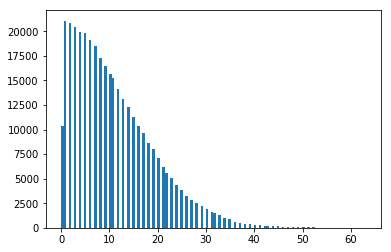

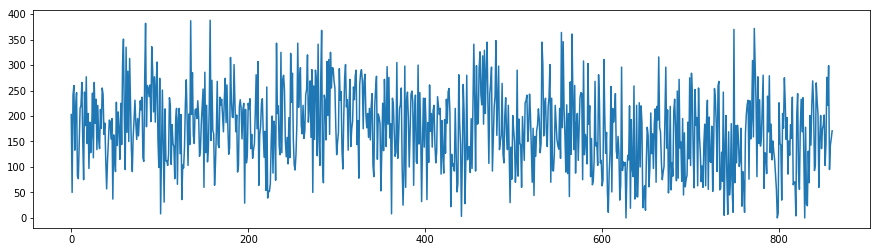

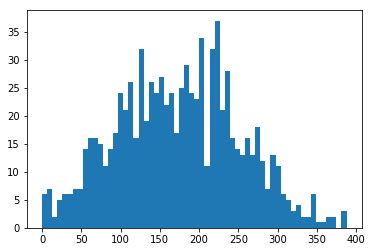

In [22]:
#nneeded = needed_correct_predictions(dy, needed, confidence=90, span=span)
#print(nneeded)

ny = np.convolve(np.ones(span), y, mode='same')
print('Those limits will create entering oportunities that represents only {:.2f} % of the total data'.format
      (100-stats.percentileofscore(np.abs(ny), cny))) # cny defines the desired profit on span (time == 120 minutes)
#noperday = 4 # desired number of operations per day
plt.hist(np.abs(ny), bins=120);
print('expected profit ~ {: .1f} R$'.format(pclass*cny*capital))
df['Y'] = y
df['ny'] = None
df['date'] = df.index
df.date = df.date.apply(lambda x: x.date())
### calculate ny avoiding overlap bettwen different days
for date, group in df.groupby('date'):
    df.loc[group.index, 'ny'] = abs(np.convolve(np.ones(span), group.Y.values, mode='same'))
df['bny'] = 0
df.loc[df[ df.ny > cny ].index, 'bny'] = 1
oper_day = df.groupby('date').sum() 
plt.figure(figsize=(15,4))
plt.plot(oper_day.bny.values)
print('number of days with no operations', len(oper_day[oper_day.bny.values == 0]), 
      ' total days ', df.date.nunique())
plt.figure()
plt.hist(oper_day.bny.values, bins=60);
print('95% of days will have at least {: 5d} possible operations'.format(
    int(np.floor(np.percentile(oper_day.bny.values, 5)))))

In [23]:
i=0
e=400

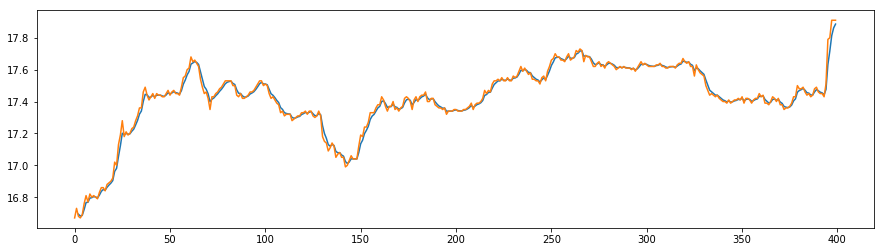

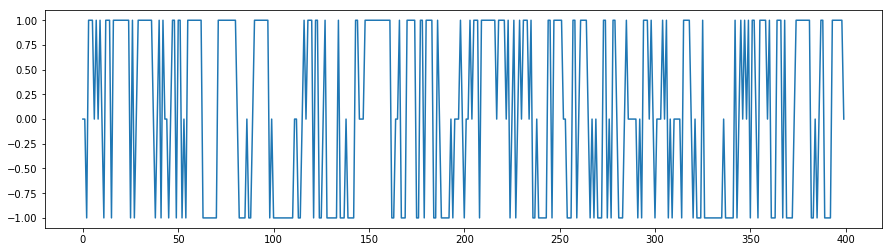

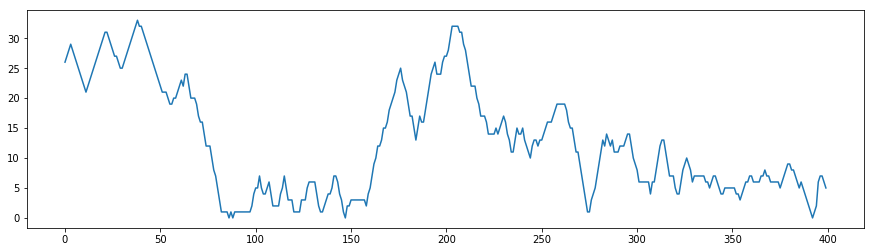

In [24]:
plt.figure(figsize=(15,4))
plt.plot(ema[i:e])
plt.plot(df['VALE3_C'][i:e].values)
plt.figure(figsize=(15,4))
plt.plot(df.Y.values[i:e], '-')
plt.figure(figsize=(15,4))
plt.plot(df.ny.values[i:e], '-')
#df.drop(columns=['dema_PETR4_C', 'dema_PETR4_Cr', 'ema_PETR4_C'], inplace=True)

## IF you enter 2 hours ago
what capital variation would you have?

In [12]:
%matplotlib inline

In [13]:
from matplotlib import pyplot as plt

In [24]:
vc = df.VALE3_C.values[::-1]
dy_span = np.append(vc[:-span]/vc[span:], np.zeros(span)*np.nan) # garantee same size
dy_span = dy_span[::-1]
df['dy_span'] = dy_span

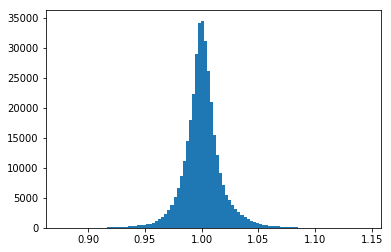

In [25]:
plt.hist(dy_span[~np.isnan(dy_span)], bins=100);

In [26]:
span

120

### Make average of 1/4. of span that is 2*60 minutes / 4. = 30 minutes
### block it by the same period

That means that for that "smoothing" period on average we have that price variation.  
Using that gains/losses might be more or less but we need something to work and that is the average (on the period).  

In [29]:
dy_spans = ta.SMA(df.dy_span.values, span/4.)
df['dy'] = dy_spans

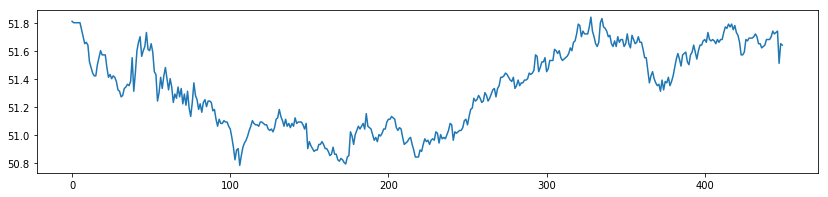

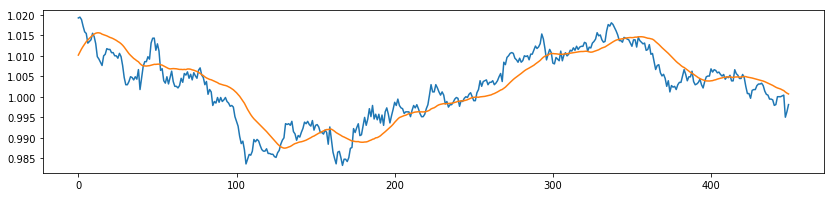

In [31]:
plt.figure(figsize=(14,3))
plt.plot(df.VALE3_C.values[-450:])
plt.figure(figsize=(14,3))
plt.plot(df.dy_span.values[-450:])
plt.plot(df.dy.values[-450:])
#plt.plot(dy_spans[-450::int(span/4.)])

In [33]:
df.resample?

### Since it is a day trade strategy its better not smooth or   
#### make influence between one day and the next one??

Better also delete all days with less than xxx hours of trading 

xxx could be 5 hours === 300 minutes

In [71]:
ta.

In [100]:
### drop all auxiliary collumns
df.drop(['ny', 'bny', 'date'], axis=1, inplace=True)

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
df.head(1)

,PETR4_O,PETR4_H,PETR4_L,PETR4_C,PETR4_T,PETR4_R,BBDC4_O,BBDC4_H,BBDC4_L,BBDC4_C,...,DOL$_O,DOL$_H,DOL$_L,DOL$_C,DOL$_T,DOL$_R,Y,ny,date,bny
time,,,,,,,,,,,,,,,,,,,,,
2014-12-16 10:14:00,8.72,8.76,8.7,8.75,153,200300,17.37,17.4,17.37,17.38,...,3658.963,3658.963,3658.297,3658.297,50,400,0,26,2014-12-16,1


### Causality assumption 
What is happenning now was caused by something that happened xxx span (n 60) minutes before  
So we shift our target class "back" in time, it is easier than moving forward all the rest  

In [102]:
df.Y = df.Y.shift(-span)

/home/andre/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### For training drop Nan's

1. on X (features) we have nan's on the beginning due the EMA (size EMA PERIOD)
2. size other EMAs period max is EMA PERIOD*3 
2. on Y (classes/labels) we have nan's on the end due the shift to past  (size SHIFT)

In [103]:
df.dropna(inplace=True)
Xtrain = df.drop(['Y'], axis=1)
ytrain = df.Y

/home/andre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
ytrain.to_pickle('PETR4_ytrain.pickle')

In [105]:
Xtrain.to_pickle('PETR4_xtrain.pickle')

In [196]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain.values)
Xtrain.iloc[:,:] = scaler.transform(Xtrain.values)

In [197]:
ys = y

C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\alferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  app.launch_new_instance()


maximum periods are hours : [ 0.27  0.35  0.43  0.34  0.48  0.74  0.54  0.69  8.82  0.29]


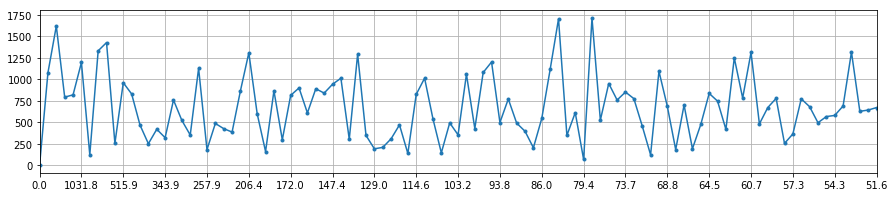

In [198]:
from scipy.fftpack import fft, fftfreq
zf = np.abs(fft(ys-np.mean(ys)))
#f[0] = 1
#Frequency axis turned in period axis
#T in hours since ys is in minutes
T = 1./fftfreq(len(zf))[:350]
T[0] = 0
T /= 60
Ti = np.round(T, 1)
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(np.arange(350), zf[:350], '.-')
plt.xticks(np.arange(350)[::5], Ti[::5])
plt.xlim(0, 100)
plt.grid()
periods = fftfreq(len(zf))[np.argsort(zf[:len(zf)//2])[::-1]]**(-1)
print('maximum periods are hours :', np.round(periods[:10]/60., 2) )

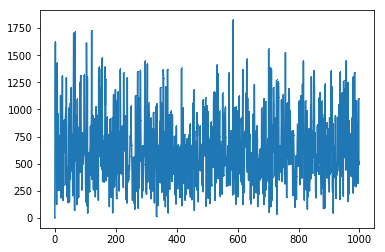

In [199]:
plt.plot(np.arange(1000), zf[:1000], ',-')

## split for 6 cores RUWindows

will create 6 prediction books

#### Create Script BAT for running ncores python instances

still not that fast because the classifier is very cpu consuming. 
would be faster if could be trained on GPU

In [8]:
shift=60
nforecast=shift
ntraining = 8*60
nwindow = nforecast+ntraining  # traininig + forecasting window
estimators=800  
span=2*60
dt=60

In [9]:
starti = 0
endi = 60*7*23

In [10]:
# all possible shifts considering the data passed : one sample by one sample
maxi = round(Xtrain.index.size-nwindow+1) # possible shifts 1 step
nanalysis = -1
if nanalysis == -1:
    nanalysis = maxi
print('percentage against the total (%)', 100*nanalysis/maxi)

percentage against the total (%) 100.0


In [8]:
def predict_paralel(starti, endi, nprocess=6, inplace=True, os='Linux'):
    size = endi-starti
    # needed samples from previous batch 
    # for prediction on the beggining of this batch
    before_neededn = ntraining+nforecast
    batch_size = int(np.floor((size-before_neededn)/nprocesses))
    nmiss = (size-before_neededn-batch_size*nprocesses) # samples to complete the non integer division
    # last batch will have more sample to complete the non integer division
    slices = np.array([i*batch_size for i in range(nprocesses)])
    # each batch must have the previous sample size of training + forecast window
    istarts = slices
    iends = slices[1:] + before_neededn
    iends = np.append(iends, size)
    # first and last batch have different size of samples
    print('batch starts ', istarts)
    print('batch ends ', iends)
    print('batch sizes ', iends-istarts) 

In [125]:
import os
try:
    os.remove('paralalel.bat')
except:
    pass
cmd = (r"start /B C:\Anaconda3\python.exe Predict.py --xtrainfile " + xtrain_file + ' '
       "--ytrainfile " + ytrain_file + ' '
       "--timefile " + index_file + ' '
       " --starti {0} --endi {1}\n")
with open('paralalel.bat', 'w') as f:
    for i, j in zip(istarts, iends):
        f.write(cmd.format(i, j))
    f.close()

## Read Prediction Results nfiles found

**Merge in in predicion book**

Just one will be enougth for while

##### all data from training to the initial "bundle" of data store in this folder

Consider removing incomplete days of data ??  
**due array slicing**

In [9]:
cd ..

/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks


In [10]:
cd data

/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/data


In [11]:
pwd

'/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/data'

In [12]:
predictions = pd.read_pickle('PETR4_0_228391_prediction.pickle')
predictions = pd.read_pickle('PETR4_0_2000_prob_prediction.pickle')

In [13]:
prediction_book = predictions
prediction_book['tindex'] = pd.to_datetime(prediction_book['tindex']) # guarantee datime objects (operational)
prediction_file = 'PETR4_0_228391_prediction'
prediction_file = 'PETR4_0_228391_prob_prediction'

In [184]:
import os

prediction_file = 'recommend_orders_152260_190325'
prediction_book = pd.read_pickle(
    os.path.join(meta5_ibov_load.path_data_bundle, prediction_file)
    )
prediction_book = prediction_book.dropna()
prediction_book = prediction_book.drop_duplicates()
prediction_book['tindex'] = pd.to_datetime(prediction_book['tindex']) # guarantee datime objects (operational)

#### due dropping reset index is mandatory

In [12]:
prediction_book.reset_index(inplace=True, drop=True)

In [14]:
print(len(prediction_book))
print(prediction_book.tindex.nunique())
print('Total data in days:', (prediction_book.tindex.max()-prediction_book.tindex.min()).days, ' days')

68869
68869
Total data in days: 792  days


### Process prediction book 

#### Add start, stop and loss  

Get the original Data with 'OPEN' 'HIGH' 'LOW' 'CLOSE' 

In [13]:
prediction_book.head()

,tindex,buy,prob
0,2016-01-05 17:35:00,-1,3.67587e-09
1,2016-01-05 17:36:00,-1,5.1318e-09
2,2016-01-05 17:37:00,-1,2.35987e-08
3,2016-01-05 17:38:00,-1,4.7925e-08
4,2016-01-05 17:40:00,-1,9.64421e-09


In [18]:
targetquote='PETR4'
df = meta5_ibov_load.CreateTargetDF(targetquote, percentdata=100, prediction_on='CLOSE')
#ibov_load.get_symbol(masterdf, targetquote).tail()
df = df.loc[prediction_book.tindex.min():prediction_book.tindex.max()]
df_quote = meta5_ibov_load.get_symbol(targetquote) # get the original data with open high low and close
df_quote = df_quote.loc[prediction_book.tindex.min():prediction_book.tindex.max()]

In [15]:
prediction_book['start'] = df.loc[prediction_book['tindex'].values, targetquote].values
# 3% might be too much will depend on capital invested and taxes/costs
prediction_book['stop'] = prediction_book['start']*(1-0.005*prediction_book['buy']) # 0.5% loss acceptable
prediction_book['gain'] = prediction_book['start']*(1+0.015*prediction_book['buy']) # 1.5% gain (RATIO 3:1)
# bounds for order evaluation, was stopped? was gain?
prediction_book['min'] = prediction_book[['stop','gain']].min(axis=1) 
prediction_book['max'] = prediction_book[['stop','gain']].max(axis=1) 
prediction_book = prediction_book.drop(columns=['stop', 'gain'])

#### Process Predicted Orders against historical data

In [16]:
### There are minute gaps on original master data  
### Have tried to get better data from metatrader but one tick or some will allways miss. 
#### Gap on data will be around 0.1% of data so I have no option but to unconsider. 
### that's why '<=' [-1] is a must on close price search by time index
### orders will close in 2 hours or less will depend on the gapped minute data

from joblib import Parallel, delayed
import multiprocessing

num_cores = 8

def isorder_expired(index, row, prediction_book, df_quote, close_time):
    """
    expire order at row - row in the prediction_book supported by df_quote
    IF NECESSARY and return True in that case
    """
    # the smallest expire_time for this order
    expire_time = min(row['expire_day'], row['expire_2hours'])
    # just passed the closing trade hour
    # or just passed expire 2 hours
    if (close_time is None) or (close_time > expire_time): 
        close_time = expire_time
        close_code = 0
        # lnast quote before expire_time
        close_price = df_quote.loc[df_quote.index <= expire_time, 'CLOSE'][-1]         
        return [close_time, close_price, close_code]           
    return None

def close_row(index, row, prediction_book, df_quote):    
#    for index, row in rf_predictor.progressbar(list(prediction_book.iterrows())):
    # evaluate after order as placed at time row['index']
    df_quote_next_times = df_quote[row['tindex']:]
    row_max = row['max']  
    row_min = row['min']  
    # time of hit index time forward projection
    up_time = df_quote_next_times.query('HIGH > @row_max').index
    down_time = df_quote_next_times.query('LOW < @row_min').index 
    up_time = up_time[0] if len(up_time) != 0 else False
    down_time = down_time[0] if len(down_time) != 0 else False 

    if (not up_time)  and (not down_time): # did not hit close order by day last trade hour
        result = isorder_expired(index, row, prediction_book, df_quote, None)
        if result is not None:
            return result  
    else:
        # what happend first is the smallest time
        # if any of those are False set to the last minute of trading
        up_time = row['expire_2hours'] if not up_time else up_time
        down_time = row['expire_2hours'] if not down_time else down_time            
        close_time = up_time if up_time < down_time else down_time
        # close order if needed 
        result = isorder_expired(index, row, prediction_book, df_quote, close_time)
        if result is not None:
            return result  
        close_price = df_quote.loc[df_quote.index <= close_time, 'CLOSE'][-1]               
        close_code = 1  
        return [close_time, close_price, close_code]

def Close_Orders(prediction_book, df_quote):
    """
    Close all orders in the prediction book 
    analysing if it was a hit Gain or hit Stop Loss
    Use `df_quotes` with values of 'HIGH' 'LOW' of future times for that.
    Create 'hit' collum with 1 for sucess (gain) or -1 for failure (stop loss)

    'daytrade'
    close orders by the end of the day
    
    order_lifespan 2 hours default
    how long should an order remain active
        g
    # create date column for join of day expire
    prediction_book['date'] = prediction_book.tindex.apply(lambda x: x.date())
    # expire by day is 30 minutes before day closing
    prediction_book = prediction_book.join(
        pd.DataFrame(date_last_trade_time-datetime.timedelta(minutes=30), columns=['expire_day']), 
        on='date')
    # remove recommended orders that would be placed in the last trading hour
    # no order should be placed on the last trading hour
    prediction_book = prediction_book.drop(
        prediction_book[(prediction_book['tindex'] > (prediction_book['expire_day'] - datetime.timedelta(minutes=30)))].index)      
    # expire by time is 2 hours of lifespam for an order
    #prediction_book['expire_2hours'] = prediction_book['tindex'] + datetime.timedelta(hours=2)
    prediction_book['expire_2hours'] = prediction_book['tindex'] + datetime.timedelta(hours=2)
    
    
    # make it parallel
    resultrows = Parallel(n_jobs=num_cores)(delayed(close_row)(index, row, prediction_book, df_quote.copy()) 
                    for index, row in rf_predictor.progressbar(list(prediction_book.iterrows())))
    resultrows = np.array(resultrows)
    prediction_book['close_time'] = resultrows[:, 0].astype(datetime.datetime)
    prediction_book['close_price'] = resultrows[:, 1].astype(np.float32)
    prediction_book['close_code'] = resultrows[:, 2].astype(np.int32)
    
    prediction_book = prediction_book.drop(columns=['expire_2hours', 'expire_day', 'date'])
    #### Orders that were hit (Closed) in the same minute
    # add 30 seconds to orders that were closed in the same minute they were openned  
    # we are working with minute time frame so that's not a problem or error 
    prediction_book.loc[prediction_book['close_time'] == prediction_book['tindex'], 'close_time'] += (
        datetime.timedelta(seconds=30))
    
    # set failure or sucess close code over orders expired
    # if you want to see wich orders were expired just comment this part
    prediction_book.loc[prediction_book.query('close_price > start and buy == 1').index, 'close_code'] = 1
    prediction_book.loc[prediction_book.query('close_price <= start and buy == 1').index, 'close_code'] = -1
    prediction_book.loc[prediction_book.query('close_price >= start and buy != 1').index, 'close_code'] = -1
    prediction_book.loc[prediction_book.query('close_price < start and buy != 1').index, 'close_code'] = 1
    return prediction_book
#             didnothit.append(index)            
#     if len(didnothit) > 0:
#         print('The orders bellow did not hit ')
#         print(prediction_book.loc[didnothit])

### Run Close Orders if

#### `prediction_file` choosen has not been previouly processed and closed

In [26]:
closed_book_file = prediction_file+'_obook_closed.pickle'
closed_book_filepath = os.path.join(meta5_ibov_load.path_data_bundle, closed_book_file)

file = Path(closed_book_filepath)
if file.is_file():
    closed_book = pd.read_pickle(closed_book_filepath)
    print('Closed Orders Book loaded!')
else:
    print('Closed Orders Book not existent! Running...')
    closed_book = Close_Orders(prediction_book, df_quote)
    # save it on data path
    closed_book.to_pickle(os.path.join(meta5_ibov_load.path_data_bundle, closed_book_file))

Closed Orders Book loaded!


In [27]:
closed_book.head()

,tindex,buy,prob,start,min,max,close_time,close_price,close_code
12,2016-01-06 10:08:00,-1,0.745596,6.50,6.40250,6.53250,2016-01-06 10:23:00,6.53,-1
13,2016-01-06 10:09:00,-1,0.756762,6.51,6.41235,6.54255,2016-01-06 12:09:00,6.50,1
14,2016-01-06 10:10:00,-1,0.745705,6.51,6.41235,6.54255,2016-01-06 12:10:00,6.50,1
15,2016-01-06 10:11:00,-1,0.752542,6.51,6.41235,6.54255,2016-01-06 12:11:00,6.50,1
16,2016-01-06 10:12:00,-1,0.737947,6.50,6.40250,6.53250,2016-01-06 10:23:00,6.53,-1


## Nice information to be obtained from the real backtesting 
#### on prediction recommendations are not that usefull

##### Cumulativo de ordens (+) posivitas  e (-) negativas 
numero ordens acumuladas compradas ou vendidas

Duas contas uma para operar comprado e outra para operar vendido... é possível em teoria

Sucess:  36246  Failure:  25733  Sucess Percentage (%):  58.48109843656722
Average gain per order with gain/stop/loss percentage (%) 1.339243937462689
61979  Order openned in  792  days
Orders per day:  78.25631313131314
Last order:  2018-03-08 13:25:00  last order closed  2018-03-08 15:25:00
Last order to last closed order gap :  0 days 02:00:00
percents:  [2.         2.         1.31666667]
90% of the orders closed in less than: 2.0  hours
70% of the orders closed in less than: 2.0  hours
50% of the orders closed in less than: 1.3166666666666667  hours


Text(0.5,0,'period between order placed and order hit/closed (hours)')

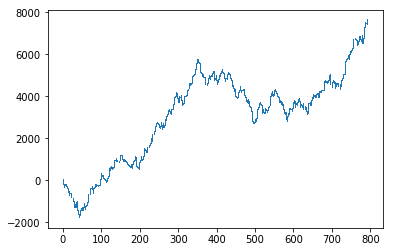

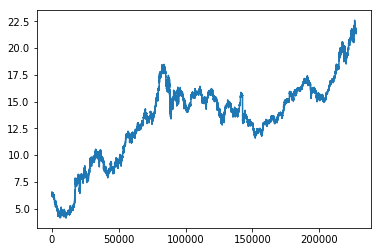

<Figure size 432x288 with 0 Axes>

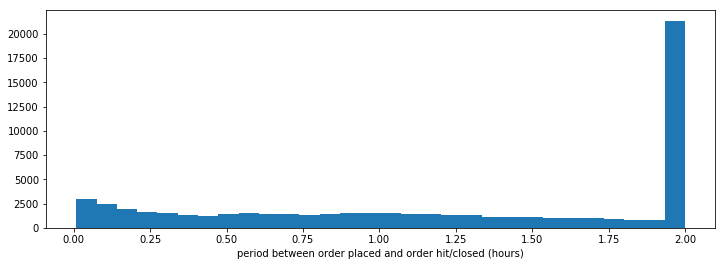

In [28]:
dtimes = closed_book['tindex'].max()-closed_book['tindex']
#plt.plot(np.cumsum(closed_book['buy']), '+')
plt.figure()
plt.plot(np.sort([ i.days for i in dtimes ]), np.cumsum(closed_book['buy']), ',')
plt.figure()
plt.plot(df_quote.loc[closed_book['tindex'].min():closed_book['tindex'].max()]['CLOSE'].values)
plt.figure()
# graph cumulative buy and sell at same shared axis
#plt.plot(np.cumsum(closed_book.loc[closed_book['buy'] > 0, 'buy'].values), 'b.')
#plt.plot(np.cumsum(closed_book.loc[closed_book['buy'] < 0, 'buy'].values), 'r.')
sucess = np.sum([1 for i in closed_book.close_code == 1 if i])
failure = np.sum([1 for i in closed_book.close_code == -1 if i])
print('Sucess: ', sucess, ' Failure: ', failure, ' Sucess Percentage (%): ', 100*sucess/(sucess+failure))
print('Average gain per order with gain/stop/loss percentage (%)', (sucess*3-failure)/(sucess+failure))
print(len(closed_book), ' Order openned in ', (closed_book['tindex'].max()-closed_book['tindex'].min()).days, ' days')
print('Orders per day: ', len(closed_book)/(closed_book['tindex'].max()-closed_book['tindex'].min()).days)
print('Last order: ', closed_book['tindex'].max(), ' last order closed ', closed_book['close_time'].max())
print('Last order to last closed order gap : ', closed_book['close_time'].max()-closed_book['tindex'].max() )
# P90 - orders spam are bigger than periods of 1 hour:
percents = np.percentile([ i.total_seconds()/(3600) for i in (closed_book['close_time']-closed_book['tindex']) ], [90, 70, 50])
print('percents: ', percents)
print('90% of the orders closed in less than:', percents[0] ,' hours')
print('70% of the orders closed in less than:', percents[1] ,' hours')
print('50% of the orders closed in less than:', percents[2] ,' hours')
plt.figure(figsize=(12,4))
plt.hist([ i.total_seconds()/(3600) for i in (closed_book['close_time']-closed_book['tindex'])], bins=30);
plt.xlabel('period between order placed and order hit/closed (hours)')

### Real World Finite Money

#### Evaluating price variation in percentage to guide expected gain

use 1 stdev is reazonable for expected gain

mean price variation (stdev) in the period % 0.07600728489662631


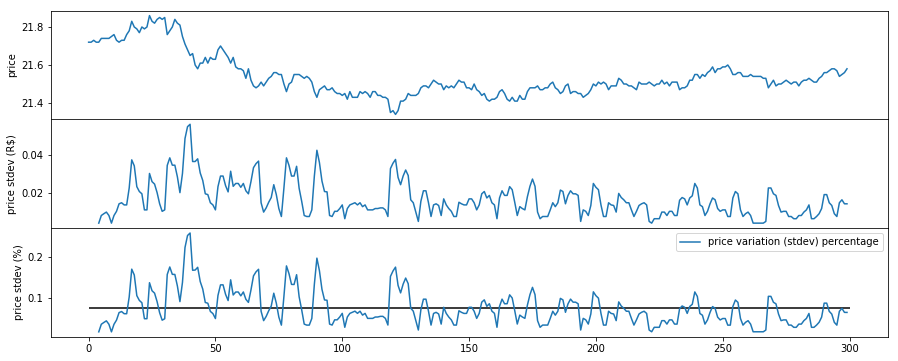

<Figure size 720x216 with 0 Axes>

In [29]:
#plt.plot(ta.STDDEV(df_quote['CLOSE'].values, 60))
import talib as ta
f, axr = plt.subplots(3, sharex=True, figsize=(15,6))
f.subplots_adjust(hspace=0)
#axr[0].plot(X[target_quote].values)

axr[0].plot(df_quote['CLOSE'].values[-300:])
axr[0].set_ylabel('price')
plt.figure(figsize=(10,3))
std = ta.STDDEV(df_quote['CLOSE'].values[-300:])
price = df_quote['CLOSE'].values[-300:]
axr[1].plot(std, label='price variation (stdev)')
axr[1].set_ylabel('price stdev (R$)')
avgstd = 100*std/price
avgstdmean = np.mean(avgstd[~np.isnan(avgstd)])
print('mean price variation (stdev) in the period %', avgstdmean)
axr[2].plot(avgstd, label='price variation (stdev) percentage')
axr[2].hlines(avgstdmean, 0, len(avgstd))
#axr[1].plot(ta.VAR(df_quote['CLOSE'].values[-600:], 60))
#arx
axr[2].set_ylabel('price stdev (%)')
axr[2].legend()

In [30]:
costorder = 15. # RS$
ir = .20 # 20% day trade imposto 
minp = 300 # 300 R$ minimum profit per order expected
exgain = 1. # expected gain on the operation

Needed number of stocks based on:  

* Minimal acceptable profit $MinP$ (in R$)

* Cost per order $CostOrder$   (in R$)  

* Taxes: $IR$ imposto de renda  (in 0-1 fraction)

* Enter Price $EnterPrice$

* Expected gain on the operation $ExGain$ (reasonable)  (in 0-1 fraction)

$$ N_{stocks} \ge \frac{MinP+2 \ CostOrder}{(1-IR)\ EnterPrice \ ExGain} $$

Be reminded that Number of Stocks MUST BE in 100s.

##### Only for buying (long) orders for selling (short) orders `EnterPrice` is the expected final price with gain???

This guarantees a `MinP` per order

In [31]:
def Nstocks(enterprice, exgain, minp=300, costorder=15., ir=0.2):
    # round stocks to 100's
    return np.ceil(int((minp+costorder*2)/((1-ir)*enterprice*exgain))/100)*100

### Process closed book of orders considering the previous expected gain of
altough not very orthodox comparing with the stdev from the time

Make operations just when money is available 

future: (SWING TRADE)  
consider D+3 for selling and receiving money back on account  
Prejuizos ordens atingindo STOP no aftermarket or open market  
Ou lucro tambem...  
### Money flow +
Governament profit taxes

In [32]:
gain_percent = 0.015
stop_percent = 0.005
tclosed_book = closed_book.set_index('tindex', drop=True, inplace=True) 
closed_book['nstocks'] = (
    closed_book['start'].apply(Nstocks, exgain=gain_percent))
closed_book['moneyspent'] = ( 
    closed_book.apply(lambda x: x['nstocks']*x['start']+costorder, axis=1))
closed_book['profit'] = ( 
    closed_book.apply(lambda x: x['nstocks']*(x['close_price']-x['start'])*x['buy']-costorder, axis=1))
closed_book.loc[ closed_book['profit'] > 0, 'profit'] *= (1-ir) # if IR pay it
closed_book['moneyresult'] = closed_book['profit'] + closed_book['moneyspent']

In [33]:
closed_book.profit.sort_values().head(2)

tindex
2016-05-09 12:22:00   -759.000237
2016-03-17 10:32:00   -505.000134
Name: profit, dtype: float64

In [26]:
closed_book.profit.sort_values().tail(2)

tindex
2016-05-09 12:05:00    1139.999176
2016-05-09 12:03:00    1139.999176
Name: profit, dtype: float64

In [27]:
closed_book.head(2)

,buy,prob,start,min,max,close_time,close_price,close_code,nstocks,moneyspent,profit,moneyresult
tindex,,,,,,,,,,,,
2016-01-06 10:08:00,-1,0.745596,6.50,6.40250,6.53250,2016-01-06 10:23:00,6.53,-1,4300.0,27965.0,-144.000902,27820.999098
2016-01-06 10:09:00,-1,0.756762,6.51,6.41235,6.54255,2016-01-06 12:09:00,6.50,1,4300.0,28008.0,22.400000,28030.400000


#### Place Orders and Record Money Evolution

##### Merge order times and close_times in a new dataframe of times (unified time of events)
Every 0 means money coming back to the pouch (if order was previous placed)  
Every 1 means we buy (if money is available)  

Sort by times and hitting. Hitting times allways come first. (0 - hit allways before 1 - buy)

In [28]:
#times = pd.DataFrame(np.append(tclosed_book.hit_time, tclosed_book.index))
utimes = pd.DataFrame(np.append(closed_book.index, closed_book.close_time), columns=['time'])
utimes['event'] = np.zeros(len(closed_book)*2, dtype=np.int)
utimes.loc[:len(closed_book)-1, 'event'] = 1
# store original integer row indexes from tclosed_book
utimes.loc[:len(closed_book)-1, 'order_i'] = np.arange(len(closed_book), dtype=np.int) 
utimes.loc[len(closed_book):, 'order_i'] = np.arange(len(closed_book), dtype=np.int) 
utimes.sort_values(['time', 'event'], inplace=True)
utimes.reset_index(drop=True, inplace=True) # i must reset index for new sequential order
utimes.loc[:, 'time'] = utimes.time.apply(lambda x: pd.to_datetime(x))

### add collum of money flow on utimes dataframe 
now it is a unified times and events 

In [29]:
utimes['money_flow'] = 0
# negative money_flow
utimes.loc[ utimes.event > 0, 'money_flow'] = (
    -closed_book.iloc[ utimes.query('event > 0').order_i.values.astype(np.int)]['moneyspent'].values)
# positive money_flow
utimes.loc[ utimes.event < 1, 'money_flow'] = (
    closed_book.iloc[ utimes.query('event < 1').order_i.values.astype(np.int)]['moneyresult'].values)

## Real Strategy Tester Goes Here

#### Want to simulate for a period 4 weeks as many scenarios as possible

If the algorithm is allways profitable in month certainly it must be for any range.

Use > 100 days data and create sliding windows of month's

Again if profitable must be tested in as much data as possible

In [30]:
# i = 0
# while i < 10: #len(utimes):
#     print(i)
# #     i += 1
# placed = [] 
# placed.append(utimes.order_i[25])
# # pair order_i "order_id" and expire time ('index at utimes')
# placed.append#(utimes.order_i[25])
# placed.append([utimes.order_i[55], utimes.loc[utimes.order_i == utimes.order_i[55]].index[1]])
# placed.remove(23)
# utimes.loc[utimes.order_i == utimes.order_i[55]]
#utimes.sort_values(['order_i', 'event'], ascending=[True, False])

### Optimization Two: arrays With Numba

Removing DateTime objects aiming for pure np.float arrays

Also there is direct correlation bettween index i and times

## 125 X faster

In [31]:
import numba

@numba.jit#(nopython=True)
def SimulateOp(capital, etimes):
    money = capital # start with initial capital
    openorders = 0 # no orders opened
    placed = []  # no order placed
    
    # progress of money and orders, preallocate memory by setting index size
    # pandas dataframe are very heavy (low performance) for settting values
    # better use a simple list    
    #['money', 'openorders', 'time'], index=np.arange(len(utimes))) 
    #dfmoney.append({ 'money': money, 'openorders': openorders})
    dfmoney = []
    
    #for j_row in rf_predictor.progressbar(list(etimes.iterrows())):
    for i in range(len(etimes)): 
        event = etimes[i][0]        
        order_i = etimes[i][1]
        money_flow = etimes[i][2]
        # it is a hit event
        # money is back to the pouch if order was previously placed
        if event < 1 and (order_i in placed):
            money += money_flow
            openorders -= 1
            # update the money, order and time for graphing
            # i corresponds to a specific time on etimes
            dfmoney.append([money, openorders, i]) 
            # placed.remove(row.order_i) ?? is needed??
        # it is a buy event if there is enough money
        elif event > 0 and (-money_flow) < money:
            money += money_flow # buy long or buy short
            openorders += 1
            placed.append(order_i)            
        
        # replace by .loc[0] = [money, openorders, time], .loc[1] .loc[2] etc... 14x faster than append
        # just when no orders open
            
            
    return placed, dfmoney

## Simulate thousand of scenarios of trading during one month
#### using `closed_book` of orders
Each scenario 22 days period of trading == 1 month  
all orders expire in 2 hours or less  
so we can window the data considering the last buy + 2 hours  
We just remove from the last 2 hours of the window any buy order  

In [32]:
def Metrics(capital, utimes_slice, dfmoney, placed, closed_book, start):
    """
    capital : initial capital
    money progress record : dfmoney
    placed : order_id or index (from closed_book) that were placed
    closed_book : book of closed orders sorted by time
    """
    torder_executed = closed_book.iloc[np.array(placed, dtype=np.int)]
    nsucess = len(torder_executed.query('close_code > 0'))
    nfailure = len(torder_executed.query('close_code < 0'))
    time_invested = pd.to_datetime(utimes_slice.time.values[-1])-pd.to_datetime(utimes_slice.time.values[0])
    pmoney = dfmoney.loc[dfmoney.openorders == 0]
    percentiles = np.percentile((pmoney.money.values/capital)-1, [0, 10, 50, 90, 100])
    orders_per_day = (nsucess+nfailure)/time_invested.days
    final = (dfmoney.money.iloc[-1]-capital)/capital
    return [nsucess, nfailure, percentiles, orders_per_day, final, start]

# 60 k R$
def SimulateScenarios(utimes, closed_book, capital=60000, nsim=-1, random=False):
    """
    random == True for Monte Carlo simulation recommended when nsim < maximum
    else simulate like a sliding window all possible scenarios
    """
    metrics = []
    # possible starts for considering when windowing the data (size - windowsize)
    istarts = utimes.loc[utimes.event == 1]
    # 22 business days for testing
    istarts = istarts.loc[ istarts.time < (istarts.iloc[-1].time - datetime.timedelta(days=22, hours=1))] 
    
    if nsim==-1: # maximum simulations
        nsim = len(istarts)
    
    print('possible number of simulations: ', len(istarts))
    print('fraction in execution: ', nsim/len(istarts))

    if random:
        istarts = istarts.sample(frac=1) ### random start

    for i in rf_predictor.progressbar(np.arange(nsim)):
        # those are valid starts, remove the size of the window
        start =  pd.to_datetime(istarts.time.values[i])
        end = start + datetime.timedelta(days=22)
        utimes_slice = utimes.query('time >= @start & time < @end').copy()
        last_time = utimes_slice.time.values[-1]
        ##**remove all buy orders from the last 2 hours of this slice**
        limit = pd.to_datetime(last_time) - datetime.timedelta(hours=2, minutes=1)
        utimes_slice = utimes_slice.drop(utimes_slice.query('(time >= @limit) & (event == 1)').index)

        ### lets consider finite money
        etimes = utimes_slice
        # optimization with double arrays loops with numba X 125 times against pandas dataframe
        placed, dfmoney = SimulateOp(capital, etimes.drop(columns='time').values)  
        #placed, dfmoney = SimulateOp(capital, utimes_slice)        
        dfmoney = pd.DataFrame(dfmoney, columns=['money', 'openorders', 'i'])
        # some metrics
        metrics.append(Metrics(capital, utimes_slice, dfmoney, placed, closed_book, start))
        
    return metrics

def SimulateScenario(utimes, closed_book, capital=60000, avoid_open=True):
    """
    
    avoid open : True
        Remove last two hours of buy events to avoid problems        
        all buy events on `utimes` must be closed by the last time 
        otherwise simulation will fail. 
    """
    
    if avoid_open:
        last_time = pd.to_datetime(utimes.time.values[-1])
        ##**remove all buy orders from the last 2 hours of this slice**
        limit = pd.to_datetime(last_time) - datetime.timedelta(hours=2, minutes=1)
        utimes_slice = utimes.drop(utimes.query('(time >= @limit) & (event == 1)').index)

    # optimization with double arrays loops with numba X 125 times against pandas dataframe
    placed, dfmoney = SimulateOp(capital, utimes_slice.drop(columns='time').values)  
    dfmoney = pd.DataFrame(dfmoney, columns=['money', 'openorders', 'i'])
    
    return dfmoney, utimes_slice, placed

In [33]:
%%time
metrics = SimulateScenarios(utimes, closed_book, capital=60000)

possible number of simulations:  60395
fraction in execution:  1.0
[################################################################################] 60395/60395
CPU times: user 19min 48s, sys: 15.3 s, total: 20min 4s
Wall time: 19min 22s


### Plotting for quality control of what is going on in certain time span

Add time collum on money progress array

In [34]:
def plot_executed(starti, endi, dfmoney, closed_book, utimes_slice , df_quote, on='CLOSE'):
    dfmoney['time'] = utimes_slice.iloc[dfmoney.i.astype(np.int).values]['time'].values    
    subset_book = closed_book.iloc[utimes_slice.iloc[dfmoney[starti:endi].i.astype(np.int).values]
                                    ['order_i'].astype(np.int).values]
    tmin = subset_book.index.min()
    tmax = subset_book.index.max()
    subset_df_quote = df_quote.loc[tmin:tmax]
    high = subset_df_quote['HIGH'].values
    low = subset_df_quote['LOW'].values
    close = subset_df_quote['CLOSE'].values
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(111);
    xi = list(range(len(high)))# x indexes to overwrite
    ax1.plot(xi, high, 'b--', lw=0.7)
    ax1.plot(xi, close, 'k', lw=0.7)
    ax1.plot(xi, low, 'r--', lw=0.7)
    ax1.set_ylabel('Price R$', fontsize=13);
    # overwright the x axis completely
    hminute = [x.minute for  x in subset_df_quote.index]
    hhour = [x.hour for  x in subset_df_quote.index]
    #hminute = [x.time() for  x in subset_df_quote.index]

    for time, row in subset_book.iterrows():
        #print(row)
        xtimestart = time
        xstart = len (subset_df_quote) - len ( subset_df_quote.loc [ subset_df_quote.index > xtimestart ] )
        ystart = row.start
        xtimend = row.close_time
        xend = len (subset_df_quote) - len ( subset_df_quote.loc [ subset_df_quote.index > xtimend ] )
        yend = row.close_price    
        if row.buy == 1:
            # not easy to put legend
            plt.plot(xstart, ystart, '^b', alpha=0.9, ms=10.) # label='buy'
        else:
            plt.plot(xstart, ystart, 'vg', alpha=0.9, ms=10.) # label='sell'
        if row.close_code == 1: # suceed
            plt.plot(xend, yend, '.', color='cyan', alpha=0.5, ms=35.)
        else: # failed
            plt.plot(xend, yend, '.r', alpha=0.4, ms=35.)
        #dx = (xend-xstart)*0.95
        #dy = (yend-ystart)*0.95
        #ax1.arrow(xstart, ystart, dx, dy, head_width=0.1, head_length=1, lw=0.025)
        plt.plot([xstart, xend], [ystart, yend], '-k', lw=0.5, alpha=0.5)

    ax1.set_xticks(xi[::20])
    ax1.set_xticklabels(hminute[::20])
    ax1.set_xlabel('time (min)', fontsize=14)
    ## Second axis Hour
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    # unique hours labels upper axis
    uniques = np.unique(hhour)
    xislb = np.sort([ hhour.index(i) for i in uniques ] )
    xis = [ xi[i] for i in xislb ]
    xis_labels = [ hhour[i] for i in xislb]
    ax2.set_xticks(xis)
    ax2.set_xticklabels(xis_labels)
    ax2.set_xlabel('time (hour)', fontsize=14)
    #plt.setp(ax1.get_xticklabels(), fontsize=14);
    #plt.setp(ax2.get_xticklabels(), fontsize=14);
    ax1.grid()
    plt.show()
#   return subset_book

In [35]:
dfmoney, utimes_slice, tmp  = SimulateScenario(utimes, closed_book, capital=60000)

In [36]:
starti = 150
endi = starti + 15
# to make by time use this dfmoney.query('(time >= @limit) & (time <= @tend)')
tstart = None
tend = None

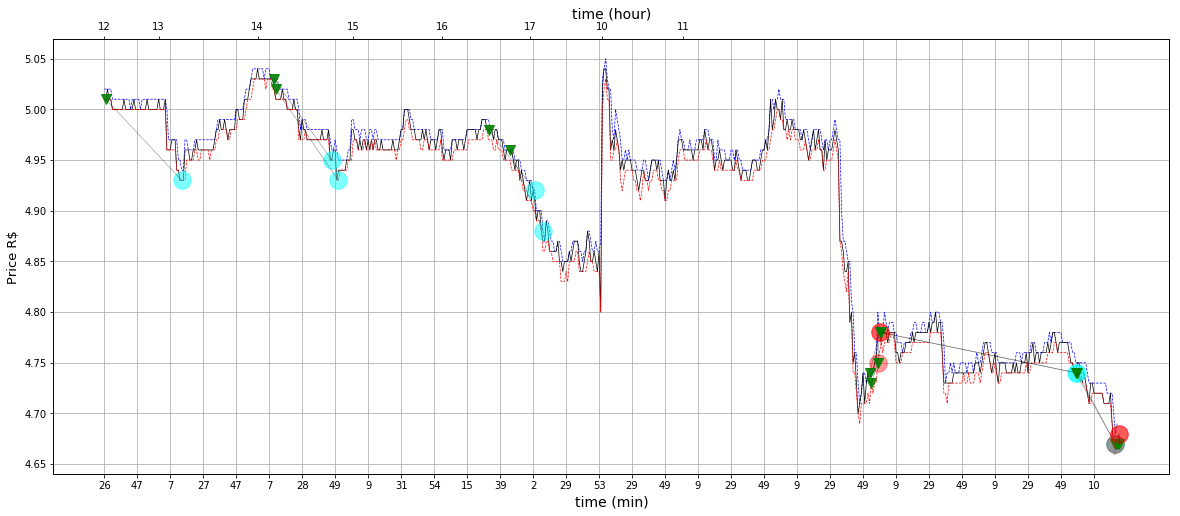

In [37]:
plot_executed(starti, endi, dfmoney, closed_book, utimes_slice, df_quote, on='CLOSE')

In [38]:
#plt.figure(figsize=(15,7))
#plt.boxplot(dfmetrics.percentiles.values)
#plt.plot(np.arange(1, len(dfmetrics)+1), dfmetrics.final.values,'.-.')

In [39]:
dfmetrics = pd.DataFrame(metrics, columns=['nsucess', 'nfailure', 'percentiles', 'orders_per_day', 'final', 'start'])
dfmetrics['final'] *= 100 # in percent

from scipy import stats
print('You have {:.0f}'.format(100-stats.percentileofscore(dfmetrics.final.values, 0)), 
      '% of chance of ending up with zero or more money $$')
print('You have {:.0f}'.format(100-stats.percentileofscore(dfmetrics.final.values, 1.0)), 
      '% of chance of ending up with +1.0% or more money $$')
dfmetrics.to_pickle('metrics_'+prediction_file+'_60k_1h5percent_300.pickle')

You have 90 % of chance of ending up with zero or more money $$
You have 84 % of chance of ending up with +1.0% or more money $$


In [40]:
def probability_sim(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=100, density=True);
    ax1.bar(percentiles[0], 0.02, width=0.1,  color='r')
    ax1.bar(percentiles[1], 0.02, width=0.1,  color='r')
    ax1.bar(0, 0.02, width=0.1,  color='k')
    ax1.bar(percentiles[2], 0.02, width=0.1,  color='b')
    ax1.bar(percentiles[3], 0.02, width=0.1,  color='b')
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()

    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=100, density=True, cumulative=True);
    ax2.bar(percentiles[0], 0.2, width=0.1,  color='r')
    ax2.bar(percentiles[1], 0.2, width=0.1,  color='r')
    ax2.bar(0, 0.2, width=0.1,  color='k')
    ax2.bar(percentiles[2], 0.2, width=0.1,  color='b')
    ax2.bar(percentiles[3], 0.2, width=0.1,  color='b')
    ax2.set_xlabel('profit (%)', fontsize=13)
    #ax2.set_xlim(percentiles[0], 5)
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

In [41]:
len(dfmetrics)

60395

percentiles are  [-8.88201256 -3.49759075 -0.06106027  4.19632535  9.08666823]


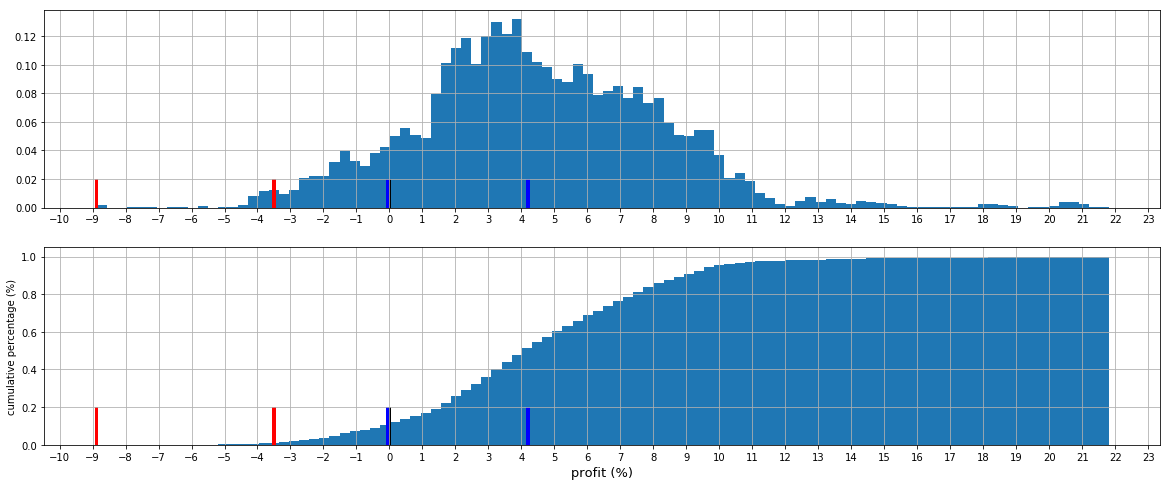

In [42]:
probability_sim(dfmetrics.final.values)

Text(45.125,0.5,'sucess rate of orders average (%)')

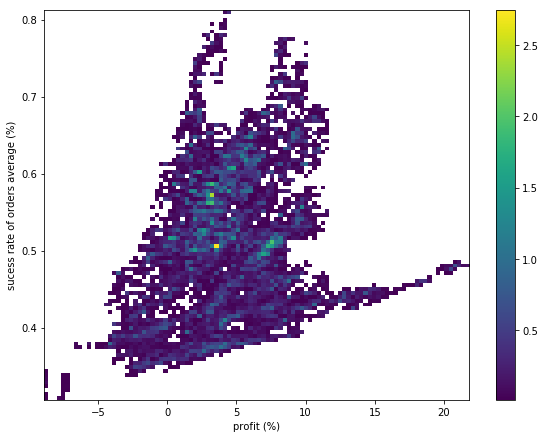

In [43]:
plt.figure(figsize=(8,6))
sucess_rate = dfmetrics.nsucess.values/(dfmetrics.nfailure.values+dfmetrics.nsucess.values)

plt.hist2d(dfmetrics.final.values, dfmetrics, bins=100, normed=True, cmap='viridis', cmin=0.01);
plt.colorbar()
plt.tight_layout()
plt.xlabel('profit (%)')
plt.ylabel('sucess rate of orders average (%)')

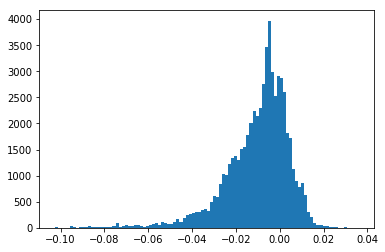

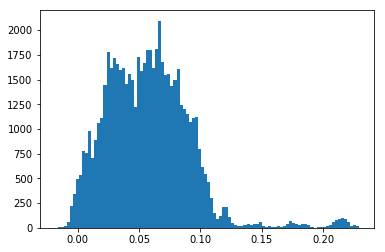

In [39]:
plt.figure()
plt.hist(dfmetrics.apply(lambda x: x[2][0], axis=1).values, bins=100);
plt.figure()
plt.hist(dfmetrics.apply(lambda x: x[2][-1], axis=1).values, bins=100);

Text(0.5,1,'color is lowest profit value during trading period (%)')

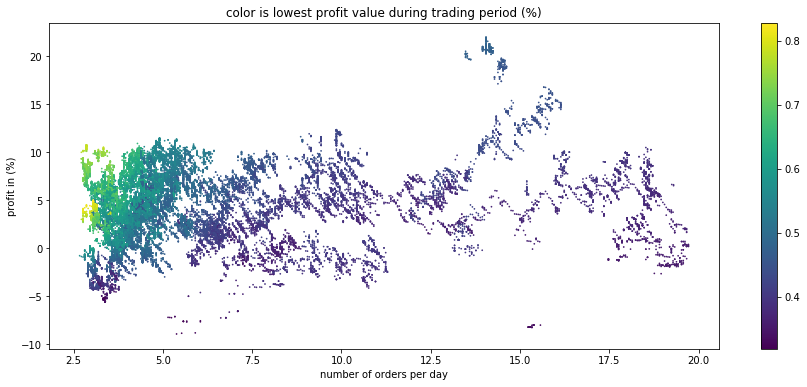

In [45]:
plt.figure(figsize=(15,6))
plt.scatter(dfmetrics.orders_per_day.values, dfmetrics.final.values, s=0.5, 
            c=sucess_rate)
plt.colorbar()
plt.xlabel('number of orders per day')
plt.ylabel('profit in (%)')
plt.title('color is lowest profit value during trading period (%)')

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# create stacked errorbars:
plt.errorbar(np.arange(len(dfmetrics)), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(len(dfmetrics)), means, [means - mins, maxes - means],
             fmt='.k', ecolor='gray', lw=1)

NameError: name 'means' is not defined

In [284]:
plt.scatter?

In [73]:
percentiles

array([-0.14784   ,  0.02597733,  0.22668667,  0.34618867,  0.59782333,
        0.82373667])

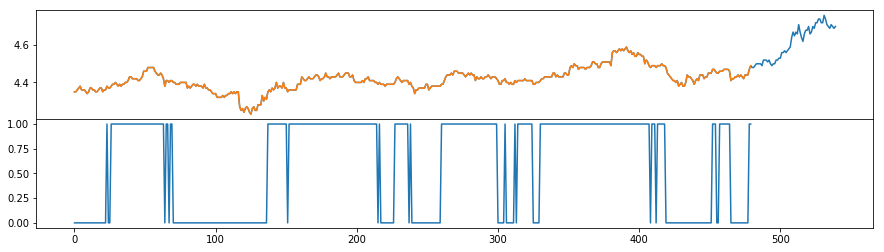

In [116]:
f, axr = plt.subplots(2, sharex=True, figsize=(15,4))
f.subplots_adjust(hspace=0)
#axr[0].plot(X[target_quote].values)

axr[0].plot(df.loc[index_window, 'PETR4'].values)
axr[0].plot(df.loc[index_window, 'PETR4'].values[:-60])
plt.figure(figsize=(10,3))
axr[1].plot(pp.srdu[index_window].values[:-60])

In [ ]:
x = result[2]
x['accuracy'] = x['right'].apply(lambda x: 1 if x else 0)
x['index'] = dfdata.ix[x['buyindex']].index # get original time index for the buying time
dfaccuracy = x.set_index('index')

### Create class of regions where the prediction worked acceptable ###

use median filters for that

In [ ]:
fig, axr = plt.subplots(2, sharex=True, figsize=(15,5))
dfaccuracy.accuracy.plot(style='*', figsize=(15,5), ax=axr[0])
#plt.subplots_adjust()
dfaccuracy['accuracy_mean'] = dfaccuracy.accuracy.rolling(11).mean(center=True)
dfaccuracy['accuracy_mean'].plot(style='b-', ax=axr[0])
dfaccuracy['accuracy_class'] = dfaccuracy.accuracy.rolling(11).median(center=True)
dfaccuracy['accuracy_class'].plot(style='.g-', ax=axr[0])
dfaccuracy['accuracy_class4'] = dfaccuracy['accuracy_mean'].apply(lambda x: 0 if x < 0.6 else 1.)
dfaccuracy['accuracy_class4'].plot(style='*b-', ax=axr[1])
dfaccuracy['accuracy_class5'] = dfaccuracy['accuracy_class4'].rolling(7).median(center=True)
dfaccuracy['accuracy_class5'].plot(style='*g-', ax=axr[1])

In [ ]:
dfaccuracy.boxplot('accuracy_mean', by='accuracy_class5', figsize=(7,5))
plt.ylim(-0.5, 1.5)

In [ ]:
%%time
import itertools

# testing on one minute
trainsize = np.arange(60, 120, 20)
shift = np.arange(2, 11, 2)
estimators = np.arange(100, 2001, 200)
span = np.arange(3, 20, 5)
paramcombinations = list(itertools.product(*[trainsize, shift, estimators, span]))
comb_params = pd.DataFrame(paramcombinations, columns=['train_size', 'shift', 'estimators', 'span'])
params = comb_params.to_dict('records')

nanalysis = 200 # nuumber of analysis (samples inputed) even though crossings are defined by span 
# indirectly
vs = []
for i, param in enumerate(params):
#    iqoption_strategy_tester(dfdata, target_quote, train_size, shift, 
#                         estimators=800, span=20, dt=60, plot=False)
    #i=241
    #param = params[i]
    datasize = nanalysis+param['train_size']+param['shift']+1
    result = iqoption_strategy_tester(dfdata[0:datasize], targetquote, **param)
    #v = np.array(result[:2]) # mean and std
    #v[1] = 1-v[1] # convert std to 1 scale the bigger the better
    #v = np.sqrt(np.vdot(v, v))
    vs.append((result[:2], len(result[2])))    
    print(i)
    #break

In [ ]:
dfresult = pd.DataFrame(params) 
dfresult['accuracy'] = np.array([vs[i][0][0] for i in range(len(vs))])
dfresult['std'] = np.array([vs[i][0][1] for i in range(len(vs))])
dfresult['n'] = np.array([vs[i][1] for i in range(len(vs))])dfresult.boxplot('accuracy', by='shift')

In [ ]:
dfresult['accuracy'] = np.array([vs[i][0][0] for i in range(len(vs))])
dfresult['std'] = np.array([vs[i][0][1] for i in range(len(vs))])
dfresult['n'] = np.array([vs[i][1] for i in range(len(vs))])
dfresult = dfresult.drop(dfresult.loc[dfresult['n']==1].index)

In [ ]:
dfresult.head(4)

In [ ]:
dfresult.boxplot('std', by='estimators')

In [ ]:
dfresult.boxplot('accuracy', by='estimators')

In [ ]:
dfresult.boxplot('n', by='estimators')

In [ ]:
dfresult.boxplot('accuracy', by='train_size')

In [ ]:
dfresult.boxplot('accuracy', by='shift')

In [ ]:
dfresult.sort_values(by='accuracy', ascending=False)

In [ ]:
dfresult.boxplot('std', by='shift')

In [ ]:
dfsorted = dfresult.sort_values(by='estimators')

In [ ]:
dfsorted.accuracy.plot(style='.b', lw=0.5, figsize=(15,2))

In [ ]:
dfsorted.boxplot(['accuracy'], by='train_size')

In [ ]:
dfsorted.accuracy.hist()